In [1]:
import torch
from torchvision.transforms import ToTensor, ToPILImage
from PIL.Image import open
import matplotlib.pyplot as plt
import copy
from tqdm import tnrange

%matplotlib inline

In [30]:
def ReverseKernel(kernel):
    return torch.flip(kernel, (-1,-2));

def Conv2d(input, kernel):
    out = torch.conv2d(input.unsqueeze(0).transpose(1,0), ReverseKernel(kernel).unsqueeze(0), groups=1).transpose(1,0).squeeze(0);
    return out;  
def PSNR(input,other,peakVal = None, average = False, nargout = 1):

    assert(torch.is_tensor(input) and torch.is_tensor(other)),"The first two inputs "\
    +"must be tensors."

    if peakVal is None:
        peakVal = other.max()

    assert(input.shape == other.shape), "Dimensions mismatch between the two "\
    "input tensors."

    while input.dim() < 4:
        input = input.unsqueeze(0)
    while other.dim() < 4:
        other = other.unsqueeze(0)

    N = input.numel()
    batch = input.size(0)

    if N == 0:
        SNR = float('nan')
        MSE = 0
        return SNR, MSE

    MSE = (input-other).view(batch,-1).pow(2).mean(dim=1)

    #SNR = (10*th.log(peakVal**2/MSE)).div(math.log(10))
    SNR = 10*torch.log10(peakVal**2/MSE)

    if average:
        return (SNR.mean(), MSE.mean()) if nargout == 2 else SNR.mean()
    else:
        return (SNR, MSE) if nargout == 2 else SNR

# Objective function

Here we aim to minimize the energy function $\frac{1}{2}||z-y||^2_2 + \lambda ||\nabla_x z||_1 + \lambda ||\nabla_y z||_1$ with respect to $z$. The data fidelity term $\frac{1}{2}||z-y||^2_2$ corresponds to Gaussian denoiser problem. The regularization term is inspired by both compressed sensing (L1 norm) and Tikhonov regulzrizer (norm of the gradient). This problem can not be solved analytically because of L1 norm.

In [23]:
class ObjectiveFunction(torch.nn.Module):
    def __init__(self, lam, norm, y):
        super(ObjectiveFunction, self).__init__()
        self.lam = torch.FloatTensor([lam])[0];
        self.norm = norm;
        self.x = torch.nn.Parameter(copy.deepcopy(torch.empty(y.shape)));
        self.y = y;
        self.x.data = copy.deepcopy(self.y);
        self.grad_x = torch.FloatTensor([[0,0,0],[1,-1,0],[0,0,0]]).unsqueeze(0);
        self.grad_y = torch.FloatTensor([[0,1,0],[0,-1,0],[0,0,0]]).unsqueeze(0);
    
    def init(self, data):
        self.x.data = data;
        pass;
    
    def forward(self):
        ret = (torch.norm(self.x - self.y)**2)/2 + self.lam*(torch.norm(Conv2d(self.x, self.grad_x), p=self.norm) + torch.norm(Conv2d(self.x, self.grad_y), p=self.norm));
        return ret;

# Input data

In [24]:
x_gt = (ToTensor()(open('lena.png')));
y_10 = torch.clamp(x_gt + x_gt.new_empty(x_gt.shape).normal_(mean=0, std=10/100), 0, 1);

# Show me the data!

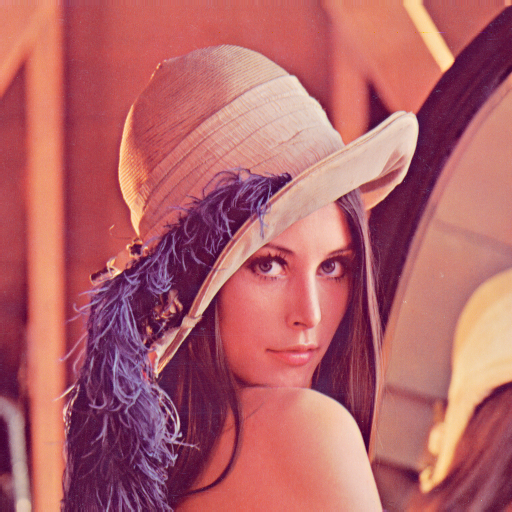

In [25]:
ToPILImage()(x_gt)

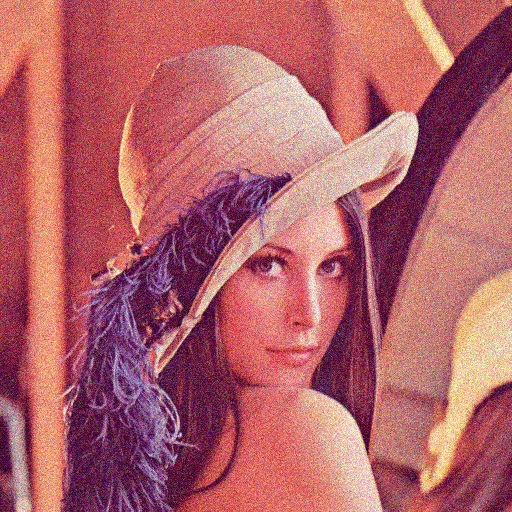

In [26]:
ToPILImage()(y_10)

# Restoring the denoised image

In [32]:
f = ObjectiveFunction(1e-1, 1, y_10);
#opt = torch.optim.SGD([f.x], lr=1e-2);
opt = torch.optim.Adam([f.x], lr=1e-2);
loss = [];
loss.append(copy.deepcopy(f.forward().data));
psnrs = [];
psnrs.append(copy.deepcopy(psnr(f.x.data, x_gt)));
for i in tnrange(100):
    f.zero_grad();
    l = f.forward();
    l.backward();
    opt.step();
    loss.append(copy.deepcopy(l.detach().data));
    psnrs.append(copy.deepcopy(psnr(f.x.data, x_gt)));
    if psnrs[-1] > psnrs[-2]:
        x_best = copy.deepcopy(f.x.data);

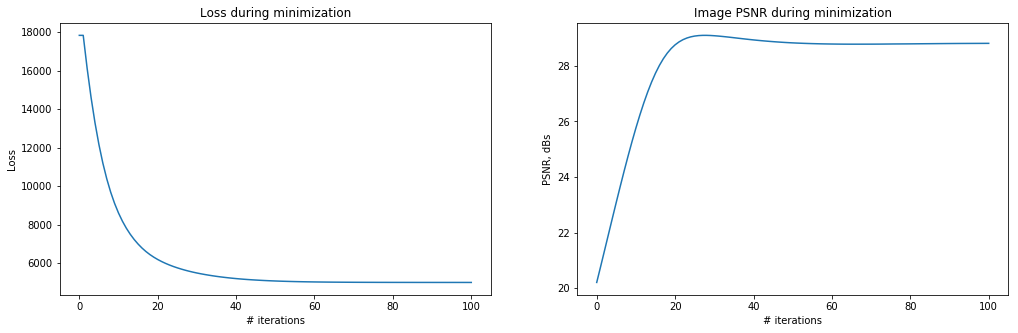

In [34]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(17,5));
ax[0].plot(loss);
ax[0].set_title('Loss during minimization');
ax[0].set_xlabel('# iterations');
ax[0].set_ylabel('Loss');

ax[1].plot(psnrs);
ax[1].set_title('Image PSNR during minimization');
ax[1].set_xlabel('# iterations');
ax[1].set_ylabel('PSNR, dBs');

# Visualize the best image obtained during restoration

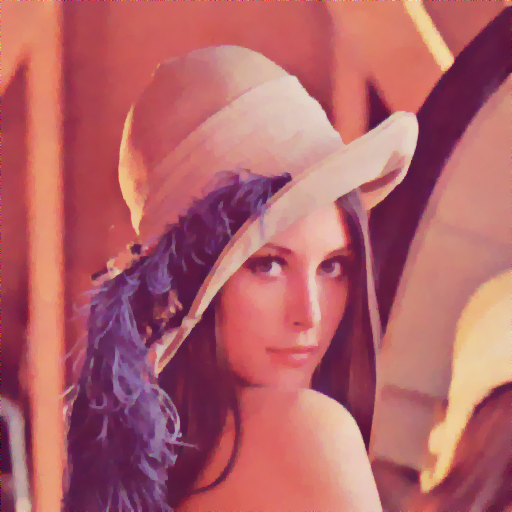

In [35]:
ToPILImage()(x_best)